#### Trial 1

In [ ]:
from collections import defaultdict
import itertools
import cvxpy as cp

class Param:
    def __init__(self, number, num):
        self.number = number
        self.num = num
    
    def __str__(self):

        return "{}v{}".format(self.num, self.number)

def merge_params(param_list):
    
    res_idx = defaultdict(int)
    
    for x in param_list:
        res_idx[x.number] += x.num
    
    result = []
    
    for x in res_idx.keys():
        if res_idx[x] != 0:
            result.append(Param(number=x, num=res_idx[x]))
    return result

def print_params(param_list):
    print("+".join(map(str, param_list)))
    
def find_param_variants(adj_matrix, I):
    
    num_params = 0 
    n = adj_matrix.shape[0]
    variable_signs = set()
    
    var_matr = [[[] for _ in range(n)] for _ in range(n)]
    for i in range(n):
        var_matr[i][i].append(1)
    
    for x in range(len(I)):
        for y in range(x+1, len(I)):
            if len(I[x].intersection(I[y])) == 2:
                
                new_idx = [num_params, num_params+1, num_params+2]
                num_params += 3
                
                inter = I[x].intersection(I[y])
                i = I[x].difference(I[y]).pop()
                j = inter.pop()
                k = inter.pop()
                l = I[y].difference(I[x]).pop()
                
                if 2 in [i,j,k,l] and 3 in [i,j,k,l]:
                  print(i, j, k, l)

                var_matr[i][j].append([Param(new_idx[0], +1)])
                var_matr[j][i].append([Param(new_idx[0], +1)])
                
                var_matr[i][k].append([Param(np.pi, +1), Param(new_idx[0], -1), Param(new_idx[1], -1)])
                var_matr[k][i].append([Param(np.pi, +1), Param(new_idx[0], -1), Param(new_idx[1], -1)])
                
                variable_signs.add(tuple([i,l]))
                
                var_matr[i][l].append([Param(new_idx[0], 1), Param(new_idx[1], 1),Param(new_idx[2], 1)])
                var_matr[l][i].append([Param(new_idx[0], 1), Param(new_idx[1], 1),Param(new_idx[2], 1)])
                
                var_matr[j][k].append([Param(new_idx[1], 1)])
                var_matr[k][j].append([Param(new_idx[1], 1)])
                
                var_matr[j][l].append([Param(np.pi, +1), Param(new_idx[1], -1), Param(new_idx[2], -1)])
                var_matr[l][j].append([Param(np.pi, +1), Param(new_idx[1], -1), Param(new_idx[2], -1)])
                
                var_matr[k][l].append([Param(new_idx[2], 1)])
                var_matr[l][k].append([Param(new_idx[2], 1)])
    
    return var_matr, num_params, variable_signs

In [ ]:
def translate_to_matrix(param_list, num_params):
    
    ai = np.zeros(num_params)
    bi = 0
    left_side = list(filter(lambda x: x.number != np.pi, param_list))
    right_side = list(map(lambda x: Param(number=x.number, num=-x.num), 
                                     filter(lambda x: x.number == np.pi, param_list)))
    for x in left_side:
        ai[x.number] += x.num

    for x in right_side:
        bi += x.number * x.num
    
    return ai, bi

def build_equalities(variants, num_params, stable_sets):
    
    A = []
    b = []
    
    ## Adding element-wise equalities
    for i in range(len(variants)):
        for j in range(i+1, len(variants)):
            if len(variants[i][j]) != 1:
                for k in range(len(variants[i][j])-1):
                    
                    all_params = variants[i][j][k] + \
                        list(map(lambda x: Param(number=x.number, num=-x.num), variants[i][j][k+1]))

                    ai, bi = translate_to_matrix(all_params, num_params)

                    A.append(ai)
                    b.append(bi)
    
    new = []
    ## Adding stable set sum inequalities
    for x in stable_sets:
        
        s = x.copy()
        i = s.pop(); j = s.pop(); k = s.pop()
        
        for first_var in variants[i][j]:
            for second_var in variants[i][k]:
                for third_var in variants[j][k]:
                    
                    total = first_var+second_var+third_var+[Param(number=np.pi, num=-1)]
                    merg = merge_params(total)
                    
                    if len(merg) != 0:
                        ai, bi = translate_to_matrix(merg, num_params)
                        if ai.max() == 2:
                            print(i,j,k)
                            print_params(first_var)
                            print_params(second_var)
                            print_params(third_var)
                            
                        A.append(ai); b.append(bi)
                        
    return np.array(A), np.array(b)

In [ ]:
def get_variance_iterator(vm, var_signs):
    
    meaningfull_variances = list(filter(lambda x: len(vm[x[0]][x[1]]) > 1, var_signs))
    total_items = sum(map(lambda x: len(vm[x[0]][x[1]]), meaningfull_variances))
    sign_permutations = itertools.product([-1,1], repeat=total_items)
    
    for m in meaningfull_variances:
      print(m)
      print(len(vm[m[0]][m[1]]))

    for perm in sign_permutations:
        c = 0
        for x in range(len(meaningfull_variances)):
            idx = meaningfull_variances[x]
            for y in range(len(vm[idx[0]][idx[1]])):
                
                for z in range(len(vm[idx[0]][idx[1]][y])):
                    el = vm[idx[0]][idx[1]][y][z].num
                    vm[idx[0]][idx[1]][y][z].num = perm[c] * np.abs(el)
                c += 1
        
        yield vm, perm

In [ ]:
def build_inequalities(num_params):

  if num_params % 3 != 0:
    print("something went wrong")
    return
  
  B = []; c = []

  # Group constraints
  for i in range(0, num_params-1, 3):

    bi = np.zeros(num_params)
    bi[i] = bi[i+1] = 1
    B.append(bi); c.append(np.pi)

    #bi = np.zeros(num_params)
    #bi[i] = bi[i+1] = -1
    #B.append(bi); c.append(0)

    bi = np.zeros(num_params)
    bi[i+1] = bi[i+2] = 1
    B.append(bi); c.append(np.pi)

    #bi = np.zeros(num_params)
    #bi[i+1] = bi[i+2] = -1
    #B.append(bi); c.append(0)

  # Individual constraints
  for i in range(num_params):
    bi = np.zeros(num_params)
    bi[i] = -1
    B.append(bi); c.append(0)

  return np.array(B), np.array(c)

In [ ]:
def solve_optim(A, b, B, c):

  num_params = A.shape[1]

  x = cp.Variable(num_params)

  func = cp.sum(cp.log( c - B@x ))

  prob = cp.Problem(cp.Maximize(func), [A @ x == b, B @ x <= c])

  return prob.solve(), x

0 1 2 3
3 1 2 7
1 2 3 4
3 2 4 7
2 3 4 5
(1, 4)
2
(2, 5)
2
(3, 7)
3
(-1, -1, -1, -1, -1, -1, -1)
got rank:  36
shape:  (830, 42)
(-1, -1, -1, -1, 1, 1, 1)
got rank:  36
shape:  (830, 42)
(-1, -1, 1, 1, -1, -1, -1)
got rank:  36
shape:  (830, 42)
(-1, -1, 1, 1, 1, 1, 1)
got rank:  36
shape:  (830, 42)
(1, 1, -1, -1, -1, -1, -1)
got rank:  36
shape:  (830, 42)
(1, 1, -1, -1, 1, 1, 1)
got rank:  36
shape:  (830, 42)
(1, 1, 1, 1, -1, -1, -1)
got rank:  36
shape:  (830, 42)
(1, 1, 1, 1, 1, 1, 1)
got rank:  36
shape:  (830, 42)


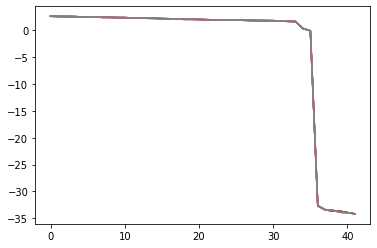

In [ ]:
# 1. Если одна расстоновка знаков допустима, то - она будет так же допустима, т.к. получаются те же уравнения связи
# Why are singular values of the matrix almost equal? Are they equivalent param? 
# fact: Checked x values - they are the same, so parametrizations are equivalent.
# fact: But on some combinations solution doesn't exist, so it is a good question to look into...

# 2. Why is the result different from out hand-made stuff?
# fact: number and combinations of lemma 4 usages is the same
# hypothesis: when doing calculations by hand i've missed some equalities on edges

g = dupl

ss = find_stable_sets(g)
vm, num_params, var_signs = find_param_variants(g, ss)

for var, perm in get_variance_iterator(vm, var_signs):
    
    A, b = build_equalities(var, num_params, ss)
    B, c = build_inequalities(num_params)
    
    val, x = solve_optim(A, b, B, c)

    if val != -np.inf:
      sing = np.linalg.svd(A)[1]

      plt.plot(np.log(sing))

      print(perm)
      #print(x.value)
      print("got rank: ",np.linalg.matrix_rank(A))
      print("shape: ", A.shape)

#### Trial 2

In [ ]:
from collections import defaultdict
import itertools
import cvxpy as cp

def build_triple_equalities(I, n):

  var_matr = np.ones([n,n], dtype=np.int)*(-1)
  num_params = 0 # thid should be n(n-1)/2 - |E|
  param_eq = []

  for ss in I:
    s = ss.copy()
    i, j, k = s.pop(), s.pop(), s.pop()

    # give number to missing parameters
    idx = [(i,j), (i,k), (j,k)]

    for id in idx:
      if var_matr[id] == -1:
        var_matr[id[0], id[1]] = num_params
        var_matr[id[1], id[0]] = num_params
        num_params += 1
    
    # start building equalities
    param_eq.append([var_matr[i,j], var_matr[i,k], var_matr[j,k]])
  

  # fill them in a matrix
  A = []
  for p in param_eq:
    ai = np.zeros(num_params)
    ai[p[0]] = ai[p[1]] = ai[p[2]] = 1
    A.append(ai)
  
  return A, var_matr, num_params 

In [ ]:
def build_variance_equalities_iterator(I, var_matr, num_params):

  # determine which edges have multiple parametrizations
  variants = defaultdict(list)

  for x in range(len(I)):
    for y in range(x+1, len(I)):
      if len(I[x].intersection(I[y])) == 2:

        inter = I[x].intersection(I[y])
        i = I[x].difference(I[y]).pop()
        j = inter.pop()
        k = inter.pop()
        l = I[y].difference(I[x]).pop()

        variants[tuple(sorted([i,l]))].append([var_matr[i,j], var_matr[j,k], var_matr[k,l]])
  
  meaningfull_variances = list(filter(lambda x: len(x) > 1, variants.values()))
  total_items = sum(map(len, meaningfull_variances))
  sign_permutations = itertools.product([-1,1], repeat=total_items)

  # now generate matricies, that are equivalent to different variants of module opening
  for perm in sign_permutations:

    A = []; b = []
    c = 0

    for var in meaningfull_variances:
      for k in range(len(var)-1):

        ai = np.zeros(num_params)
        bi = 0

        if perm[c] == 1 and perm[c+1] == 1:
          ai[var[k]] = 1; ai[var[k+1]] = -1; bi = 0
        if perm[c] == 1 and perm[c+1] == -1:
          ai[var[k]] = 1; ai[var[k+1]] = 1; bi = 2
        if perm[c] == -1 and perm[c+1] == 1:
          ai[var[k]] = 1; ai[var[k+1]] = 1; bi = 2
        else:
          ai[var[k]] = 1; ai[var[k+1]] = -1; bi = 0
        
        c += 1
        A.append(ai)
        b.append(bi)
    
    yield A, b